In [6]:
debug = True

import pandas as pd
    
import os

import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets
import numpy as np
from scipy import special

import time

# offline mode for charts, so it stays local
py.offline.init_notebook_mode(connected=True)

# read in curve data'
dirCWD    = os.getcwd()
dirIntermediate = os.path.join(dirCWD,'intermediate')
dirResults = os.path.join(dirCWD,'results')

binsize = 2

observedStage = 'v9 Final Smoothing'

baseTLFLoc = r'A:\1 - TDM\3 - Model Dev\1 - WF\2 - Sandbox\v9.0Beta\WF TDM v9.0 - 2022-11-01\Scenarios\BY_2019\3_Distribute\TLF'

# some trip purposes are added together for information purposes
dfTripPurpSubtotals = pd.DataFrame([
    ['HBOth','HBO' ],
    ['HBShp','HBO' ],
    ['NHBW' ,'NHB' ],
    ['NHBNW','NHB' ],
    ['IX'   ,'IXXI'],
    ['XI'   ,'IXXI']
],columns=('TRIPPURP','TRIPPURP_SUB'))
if debug: display(dfTripPurpSubtotals)

,TRIPPURP,TRIPPURP_SUB
0,HBOth,HBO
1,HBShp,HBO
2,NHBW,NHB
3,NHBNW,NHB
4,IX,IXXI
5,XI,IXXI


In [3]:
# read in observed TLF data to be used
dfTLF_Obs = pd.read_csv(r'A:\1 - TDM\2 - Estimate Param\_General Parameters\7 - Update Obs TLF\3 - Create Obs TLFs for all Trips\results\dfTLF_Obs_wSmoothed_20221130-133903.csv')

#filter by the STAGE for 
dfTLF_Obs = dfTLF_Obs[dfTLF_Obs['STAGE']==observedStage].copy()
dfTLF_Obs = dfTLF_Obs.drop(columns=('STAGE'))
if debug: display(dfTLF_Obs)

,BIN,TRIPPURP,FREQ,TLFTYPE
41726,0.0,HBW,0.151770,Dist
41727,2.0,HBW,0.148953,Dist
41728,4.0,HBW,0.128122,Dist
41729,6.0,HBW,0.106026,Dist
41730,8.0,HBW,0.090793,Dist
...,...,...,...,...
47871,402.0,XI_HV,0.000000,GC
47872,404.0,XI_HV,0.000000,GC
47873,406.0,XI_HV,0.000000,GC
47874,408.0,XI_HV,0.000000,GC


In [4]:
# show max bin size for TLF type to use in updating TDM TLF code
if debug: display(dfTLF_Obs[dfTLF_Obs['FREQ']>0].groupby(['TLFTYPE'],as_index=False).agg(MAXBIN=('BIN','max')))

,TLFTYPE,MAXBIN
0,Dist,160.0
1,GC,392.0
2,Time,182.0


In [7]:
# Check TLF Observed. FREQ should all sum to 1! Also show average trip length
dfTLF_Obs['BINxFREQ'] = dfTLF_Obs['BIN'] * dfTLF_Obs['FREQ']
dfTLF_Obs_Stats = dfTLF_Obs.groupby(['TRIPPURP','TLFTYPE'],as_index=False).agg(FREQ_SUM=('FREQ','sum'),AVG_TRIP_LEN=('BINxFREQ','sum'))
dfTLF_Obs = dfTLF_Obs.drop(columns=('BINxFREQ'))
if debug: display(dfTLF_Obs_Stats)

,TRIPPURP,TLFTYPE,FREQ_SUM,AVG_TRIP_LEN
0,HBOth,Dist,1.0,3.665819
1,HBOth,GC,1.0,16.186377
2,HBOth,Time,1.0,10.175627
3,HBSchPr,Dist,1.0,0.622159
4,HBSchPr,GC,1.0,8.149783
5,HBSchPr,Time,1.0,5.534968
6,HBSchSc,Dist,1.0,1.975023
7,HBSchSc,GC,1.0,11.332930
8,HBSchSc,Time,1.0,7.526669
9,HBShp,Dist,1.0,2.762367


In [8]:
# read in Friction Factors
dfsFF=[]

dfFF = pd.read_csv(r'_Friction_Factors\FricFactor_AllPurp.csv')

# make sure id column is always same: BIN
dfFF = dfFF.rename(columns={';MINUTE':'BIN','Mile':'BIN','Mil':'BIN','Min':'BIN','Bin':'BIN'})

# melt all columns but first
dfFF = pd.melt(dfFF, id_vars=['BIN'], value_vars=dfFF.columns[1:].tolist(), ignore_index=False, var_name='TRIPPURP', value_name='FF')
dfFF['FF_CALIB_ROUND']='0-Initial from v832'

dfsFF.append(dfFF)

if debug: display(dfsFF[0])

,BIN,TRIPPURP,FF,FF_CALIB_ROUND
0,0,HBW,1.000000,0-Initial from v832
1,2,HBW,0.999800,0-Initial from v832
2,4,HBW,0.609169,0-Initial from v832
3,6,HBW,0.190323,0-Initial from v832
4,8,HBW,0.098000,0-Initial from v832
...,...,...,...,...
146,292,XI_HV,0.000000,0-Initial from v832
147,294,XI_HV,0.000000,0-Initial from v832
148,296,XI_HV,0.000000,0-Initial from v832
149,298,XI_HV,0.000000,0-Initial from v832


In [9]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets
import numpy as np
from scipy import special

py.offline.init_notebook_mode(connected=True)

# Observed Plots

In [10]:
#PLOTTING FUNCTION

# chart preset zoom extents
dfZoomPresets = pd.DataFrame([
    ['Begin' ,     0,   100,     0,np.NaN],
    ['Mid'   ,    30,   160,     0, 0.018],
    ['Tail'  ,   100,   400,     0, 0.001],
    ['All'   ,np.NaN,np.NaN,np.NaN,np.NaN],
    ['Custom',np.NaN,np.NaN,np.NaN,np.NaN],
], columns=('PRESET','XMIN','XMAX','YMIN','YMAX'))
dfZoomPresets

def update_plot_obs(trippurps, tlftypes, zoompreset, xmin, xmax, ymin, ymax):

    dfAvgTripLen = pd.DataFrame()
    
    data = []
    for trippurp in trippurps:
        for tlftype in tlftypes:

            # data for plotting from filtered dataframe
            plotdata = dfTLF_Obs[(dfTLF_Obs['TRIPPURP']==trippurp) & (dfTLF_Obs['TLFTYPE']==tlftype)]

            # fill any NaN values with zeros
            plotdata = plotdata.fillna(0)
            
            xplot = plotdata['BIN']
            yplot = plotdata['FREQ']
            name  = trippurp + ' ' + tlftype 

            trace1 = go.Scatter(
                x=xplot,
                y=yplot,
                mode='lines',
                name=name,
                line=dict(
                    shape='spline'
                )
            )
            data.append(trace1)
                
    # get zoom presets
    if (zoompreset=='Custom'):
        _xmin = xmin
        _xmax = xmax
        _ymin = ymin
        _ymax = ymax
    else:
        _xmin = dfZoomPresets[dfZoomPresets['PRESET']==zoompreset]['XMIN'].values[0]
        _xmax = dfZoomPresets[dfZoomPresets['PRESET']==zoompreset]['XMAX'].values[0]
        _ymin = dfZoomPresets[dfZoomPresets['PRESET']==zoompreset]['YMIN'].values[0]
        _ymax = dfZoomPresets[dfZoomPresets['PRESET']==zoompreset]['YMAX'].values[0]

    layout = go.Layout(
        title='Trip Length Frequencies - Observed Data',
        yaxis=dict(
            title='',
            range=(_ymin,_ymax)
        ),
        xaxis=dict(
            title='GC/Dist/Time',
            range=(_xmin,_xmax)
        ),
        #width=1600,
        height=450
    )
    
    fig = go.Figure(data=data, layout=layout)
    py.offline.iplot(fig)

In [11]:
# MAKE INTERACTIVE CHART
py.offline.init_notebook_mode(connected=True)

lstTripPurp  = dfTLF_Obs['TRIPPURP'].unique().tolist() # HBW, HBShp, HBOth,...
lstTLFType   = dfTLF_Obs['TLFTYPE' ].unique().tolist() # GC, Time, Dist
    
selectTripPurp  = widgets.SelectMultiple(options=lstTripPurp, value=('HBW'        ,), description='Trip Purpose')
selectTLFType   = widgets.SelectMultiple(options=lstTLFType , value=('GC'         ,), description='TLF Type'    )
selectPreset    = widgets.Select(options=dfZoomPresets['PRESET'].tolist(), value='All', description='Zoom Presets')

#custom extents
xmin = widgets.Text(value='0', description='X Min')
xmax = widgets.Text(value='60', description='X Max')
ymin = widgets.Text(value='0', description='Y Min')
ymax = widgets.Text(value='.01', description='Y Max')

widgets.interactive(update_plot_obs, trippurps=selectTripPurp, tlftypes=selectTLFType, zoompreset=selectPreset, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

interactive(children=(SelectMultiple(description='Trip Purpose', index=(0,), options=('HBW', 'HBShp', 'HBOth',…

In [14]:
# read in trips from TDM sorted into TLF bins

tlfs=['Cost','Dist','Time']

dfTLFTDMTrips = pd.DataFrame()

for tlf in tlfs:
    
    # read in csv for tlf
    dfRead = pd.read_csv(os.path.join(baseTLFLoc,'TLF_' + tlf + '.csv'))
    
    # make sure id column is always same: BIN
    dfRead = dfRead.rename(columns={';BIN':'BIN',';MINUTE':'BIN','Mile':'BIN','Mil':'BIN','Min':'BIN','Bin':'BIN'})

    dfRead = pd.melt(dfRead, id_vars=['BIN'], value_vars=dfRead.columns[1:].tolist(), ignore_index=False, var_name='TRIPPURP', value_name='TRIPS')

    # set TLF value, rename Cost to GC
    if tlf=='Cost':
        dfRead['TLFTYPE'] = 'GC'
    else:
        dfRead['TLFTYPE'] = tlf

    # reorder columns
    dfRead = dfRead[['TLFTYPE','TRIPPURP','BIN','TRIPS']]

    # concat data into single dataframe
    dfTLFTDMTrips = pd.concat([dfTLFTDMTrips, dfRead], ignore_index=True)

if debug: display(dfTLFTDMTrips)

# create subtotals
dfTLFTDMTripsForSubtotals = pd.DataFrame.merge(dfTLFTDMTrips, dfTripPurpSubtotals, on=('TRIPPURP'))
dfTLFTDMTripsForSubtotals = dfTLFTDMTripsForSubtotals.groupby(['TLFTYPE','TRIPPURP_SUB','BIN'],as_index=False).agg(TRIPS=('TRIPS','sum'),COUNT=('TRIPS','size'))
dfTLFTDMTripsForSubtotals = dfTLFTDMTripsForSubtotals[['TLFTYPE','TRIPPURP_SUB','BIN','TRIPS']]
dfTLFTDMTripsForSubtotals = dfTLFTDMTripsForSubtotals.rename(columns={'TRIPPURP_SUB':'TRIPPURP'})
if debug: display (dfTLFTDMTripsForSubtotals)

# concat subtotals
dfTLFTDMTrips = pd.concat([dfTLFTDMTrips,dfTLFTDMTripsForSubtotals], ignore_index=True)
if debug: display(dfTLFTDMTrips)

# calculated collapsed bins
from math import floor
def round_to_binsize(x):
    return int(binsize * floor(float(x)/binsize))
dfTLFTDMTrips['BIN_COLLAPSE'] = dfTLFTDMTrips['BIN'].apply(lambda x: round_to_binsize(x))
if debug: display(dfTLFTDMTrips)

# aggregate to collapsed bins
dfTLFTDMTrips = dfTLFTDMTrips.groupby(['TLFTYPE','TRIPPURP','BIN_COLLAPSE'], as_index=False).agg(TRIPS=('TRIPS','sum'))
dfTLFTDMTrips = dfTLFTDMTrips.rename(columns={'BIN_COLLAPSE':'BIN'})
if debug: display(dfTLFTDMTrips)


,TLFTYPE,TRIPPURP,BIN,TRIPS
0,GC,HBW,0,0.00
1,GC,HBW,1,0.00
2,GC,HBW,2,5806.63
3,GC,HBW,3,21119.70
4,GC,HBW,4,16761.40
...,...,...,...,...
12649,Time,Tel_NHBW,196,0.00
12650,Time,Tel_NHBW,197,0.00
12651,Time,Tel_NHBW,198,0.00
12652,Time,Tel_NHBW,199,0.00


,TLFTYPE,TRIPPURP,BIN,TRIPS
0,Dist,HBO,0,910649.34
1,Dist,HBO,1,1034931.17
2,Dist,HBO,2,674422.97
3,Dist,HBO,3,425223.32
4,Dist,HBO,4,282306.66
...,...,...,...,...
2104,Time,NHB,196,0.00
2105,Time,NHB,197,0.00
2106,Time,NHB,198,0.00
2107,Time,NHB,199,0.00


,TLFTYPE,TRIPPURP,BIN,TRIPS
0,GC,HBW,0,0.00
1,GC,HBW,1,0.00
2,GC,HBW,2,5806.63
3,GC,HBW,3,21119.70
4,GC,HBW,4,16761.40
...,...,...,...,...
14758,Time,NHB,196,0.00
14759,Time,NHB,197,0.00
14760,Time,NHB,198,0.00
14761,Time,NHB,199,0.00


,TLFTYPE,TRIPPURP,BIN,TRIPS,BIN_COLLAPSE
0,GC,HBW,0,0.00,0
1,GC,HBW,1,0.00,0
2,GC,HBW,2,5806.63,2
3,GC,HBW,3,21119.70,2
4,GC,HBW,4,16761.40,4
...,...,...,...,...,...
14758,Time,NHB,196,0.00,196
14759,Time,NHB,197,0.00,196
14760,Time,NHB,198,0.00,198
14761,Time,NHB,199,0.00,198


,TLFTYPE,TRIPPURP,BIN,TRIPS
0,Dist,Ext_HV,0,17.60
1,Dist,Ext_HV,2,144.10
2,Dist,Ext_HV,4,399.32
3,Dist,Ext_HV,6,807.51
4,Dist,Ext_HV,8,892.52
...,...,...,...,...
7408,Time,XX,192,2.18
7409,Time,XX,194,0.49
7410,Time,XX,196,0.01
7411,Time,XX,198,0.20


In [15]:
# calculate percent distribution
dfTLFTDMTripTotals = dfTLFTDMTrips.groupby(['TLFTYPE','TRIPPURP'], as_index=False).agg(TRIP_TOTAL=('TRIPS','sum'))
if debug: display(dfTLFTDMTripTotals)

# join to toals
dfTLFTDMTripDist = pd.DataFrame.merge(dfTLFTDMTrips, dfTLFTDMTripTotals, on=('TLFTYPE','TRIPPURP'))
dfTLFTDMTripDist['FREQ'] = dfTLFTDMTripDist['TRIPS'] / dfTLFTDMTripDist['TRIP_TOTAL']
display(dfTLFTDMTripDist)

dfTLF_TDM = dfTLFTDMTripDist[['TLFTYPE','TRIPPURP','BIN','FREQ']]
display(dfTLF_TDM)

# check to see if add up to 1.0
dfCheck = dfTLF_TDM.groupby(['TLFTYPE','TRIPPURP'], as_index=False).agg(FREQ_SUM=('FREQ','sum'))
# only display results out of range
display('Not adding to 1 (if empty dataset, YAY!!!):')
display(dfCheck[(dfCheck['FREQ_SUM']<0.9999999) | (dfCheck['FREQ_SUM']>1.0000001)])

,TLFTYPE,TRIPPURP,TRIP_TOTAL
0,Dist,Ext_HV,31844.37
1,Dist,Ext_MD,36154.90
2,Dist,HBC,127503.20
3,Dist,HBO,4515770.71
4,Dist,HBOth,3652578.43
...,...,...,...
58,Time,SH_MD,687336.13
59,Time,Tel_HBW,56413.41
60,Time,Tel_NHBW,16027.51
61,Time,XI,78647.25


,TLFTYPE,TRIPPURP,BIN,TRIPS,TRIP_TOTAL,FREQ
0,Dist,Ext_HV,0,17.60,31844.37,5.526880e-04
1,Dist,Ext_HV,2,144.10,31844.37,4.525133e-03
2,Dist,Ext_HV,4,399.32,31844.37,1.253974e-02
3,Dist,Ext_HV,6,807.51,31844.37,2.535801e-02
4,Dist,Ext_HV,8,892.52,31844.37,2.802756e-02
...,...,...,...,...,...,...
7408,Time,XX,192,2.18,15337.83,1.421322e-04
7409,Time,XX,194,0.49,15337.83,3.194715e-05
7410,Time,XX,196,0.01,15337.83,6.519827e-07
7411,Time,XX,198,0.20,15337.83,1.303965e-05


,TLFTYPE,TRIPPURP,BIN,FREQ
0,Dist,Ext_HV,0,5.526880e-04
1,Dist,Ext_HV,2,4.525133e-03
2,Dist,Ext_HV,4,1.253974e-02
3,Dist,Ext_HV,6,2.535801e-02
4,Dist,Ext_HV,8,2.802756e-02
...,...,...,...,...
7408,Time,XX,192,1.421322e-04
7409,Time,XX,194,3.194715e-05
7410,Time,XX,196,6.519827e-07
7411,Time,XX,198,1.303965e-05


'Not adding to 1 (if empty dataset, YAY!!!):'

,TLFTYPE,TRIPPURP,FREQ_SUM


# Model vs Observed Plots

In [219]:
dfTLF_Obs

,BIN,TRIPPURP,FREQ,TLFTYPE
41726,0.0,HBW,0.151770,Dist
41727,2.0,HBW,0.148953,Dist
41728,4.0,HBW,0.128122,Dist
41729,6.0,HBW,0.106026,Dist
41730,8.0,HBW,0.090793,Dist
...,...,...,...,...
47871,402.0,XI_HV,0.000000,GC
47872,404.0,XI_HV,0.000000,GC
47873,406.0,XI_HV,0.000000,GC
47874,408.0,XI_HV,0.000000,GC


In [16]:
# combine TLFs of observed and TDM (from friction factor calibration process)
dfTLF_Obs['FF_CALIB_ROUND'] = 'Observed'
dfTLF_TDM['FF_CALIB_ROUND'] = '0-Initial from v832'

dfTLF_ModelvsObserved = pd.concat([dfTLF_Obs,dfTLF_TDM])
if debug: display(dfTLF_ModelvsObserved)

C:\Users\cday\AppData\Local\ESRI\conda\envs\arcgispro-py3-plotly\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,BIN,TRIPPURP,FREQ,TLFTYPE,FF_CALIB_ROUND
41726,0.0,HBW,1.517700e-01,Dist,Observed
41727,2.0,HBW,1.489535e-01,Dist,Observed
41728,4.0,HBW,1.281221e-01,Dist,Observed
41729,6.0,HBW,1.060259e-01,Dist,Observed
41730,8.0,HBW,9.079280e-02,Dist,Observed
...,...,...,...,...,...
7408,192.0,XX,1.421322e-04,Time,0-Initial from v832
7409,194.0,XX,3.194715e-05,Time,0-Initial from v832
7410,196.0,XX,6.519827e-07,Time,0-Initial from v832
7411,198.0,XX,1.303965e-05,Time,0-Initial from v832


In [79]:
#CALCUATE TRIP LENGTH AVERAGES AS TABLE AND CHART THEM
dfTLF_ModelvsObservedAve = dfTLF_ModelvsObserved
dfTLF_ModelvsObservedAve['BINxFREQ'] = dfTLF_ModelvsObservedAve['BIN'] * dfTLF_ModelvsObserved['FREQ']
dfTLF_ModelvsObservedAve_Stats = (dfTLF_ModelvsObservedAve
    .groupby(['FF_CALIB_ROUND','TRIPPURP','TLFTYPE'],as_index=False)
        .agg(FREQ_SUM=('FREQ','sum'),AVG_TRIP_LEN=('BINxFREQ','sum')))
    #rename some of the variables to better match up

dfTLF_MvO_Dif = (dfTLF_ModelvsObservedAve_Stats
    .pivot(index=['TRIPPURP','TLFTYPE'],columns="FF_CALIB_ROUND",values="AVG_TRIP_LEN")
    .reset_index(['TRIPPURP','TLFTYPE']))
    #.calculate percent dif)

if debug: display(dfTLF_ModelvsObservedAve_Stats)
if debug: display(dfTLF_MvO_Dif)


,FF_CALIB_ROUND,TRIPPURP,TLFTYPE,FREQ_SUM,AVG_TRIP_LEN
0,0-Initial from v832,Ext_HV,Dist,1.0,39.391920
1,0-Initial from v832,Ext_HV,GC,1.0,94.845462
2,0-Initial from v832,Ext_HV,Time,1.0,43.453935
3,0-Initial from v832,Ext_MD,Dist,1.0,31.847548
4,0-Initial from v832,Ext_MD,GC,1.0,74.702942
...,...,...,...,...,...
103,Observed,XI_HV,GC,1.0,162.170483
104,Observed,XI_HV,Time,1.0,72.560994
105,Observed,XI_MD,Dist,1.0,42.125143
106,Observed,XI_MD,GC,1.0,99.290194


FF_CALIB_ROUND,TRIPPURP,TLFTYPE,0-Initial from v832,Observed
0,Ext_HV,Dist,39.391920,NaN
1,Ext_HV,GC,94.845462,NaN
2,Ext_HV,Time,43.453935,NaN
3,Ext_MD,Dist,31.847548,NaN
4,Ext_MD,GC,74.702942,NaN
...,...,...,...,...
82,XI_MD,GC,NaN,99.290194
83,XI_MD,Time,NaN,48.007368
84,XX,Dist,55.216545,NaN
85,XX,GC,117.314474,NaN


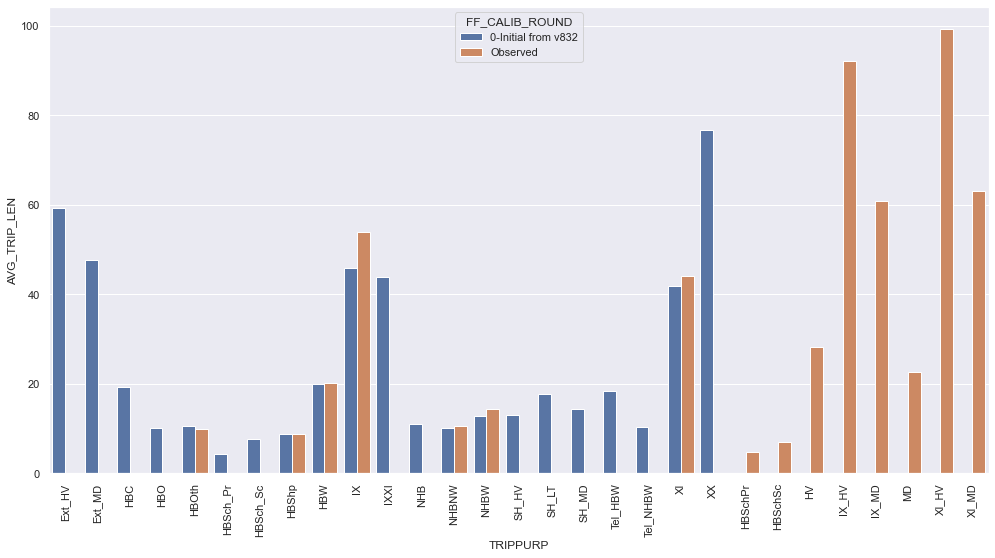

In [56]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
sns.barplot(data= dfTLF_ModelvsObservedAve_Stats,
    x ="TRIPPURP",
    y="AVG_TRIP_LEN",
    hue="FF_CALIB_ROUND",
    ci=None) \
.tick_params(axis='x', rotation=90)

In [221]:
#PLOTTING FUNCTION

# chart preset zoom extents
dfZoomPresets = pd.DataFrame([
    ['Begin' ,     0,   100,     0,np.NaN],
    ['Mid'   ,    30,   160,     0, 0.018],
    ['Tail'  ,   100,   400,     0, 0.001],
    ['All'   ,np.NaN,np.NaN,np.NaN,np.NaN],
    ['Custom',np.NaN,np.NaN,np.NaN,np.NaN],
], columns=('PRESET','XMIN','XMAX','YMIN','YMAX'))
dfZoomPresets

def update_plot_mod_vs_obs(trippurps, tlftypes, zoompreset, xmin, xmax, ymin, ymax):

    dfAvgTripLen = pd.DataFrame()
    
    data = []
    for trippurp in trippurps:
        for tlftype in tlftypes:

            # data for plotting from filtered dataframe
            plotdata = dfTLF_Obs[(dfTLF_Obs['TRIPPURP']==trippurp) & (dfTLF_Obs['TLFTYPE']==tlftype)]

            # fill any NaN values with zeros
            plotdata = plotdata.fillna(0)
            
            xplot = plotdata['BIN']
            yplot = plotdata['FREQ']
            name  = trippurp + ' ' + tlftype 

            trace1 = go.Scatter(
                x=xplot,
                y=yplot,
                mode='lines',
                name=name,
                line=dict(
                    shape='spline'
                )
            )
            data.append(trace1)
                
    # get zoom presets
    if (zoompreset=='Custom'):
        _xmin = xmin
        _xmax = xmax
        _ymin = ymin
        _ymax = ymax
    else:
        _xmin = dfZoomPresets[dfZoomPresets['PRESET']==zoompreset]['XMIN'].values[0]
        _xmax = dfZoomPresets[dfZoomPresets['PRESET']==zoompreset]['XMAX'].values[0]
        _ymin = dfZoomPresets[dfZoomPresets['PRESET']==zoompreset]['YMIN'].values[0]
        _ymax = dfZoomPresets[dfZoomPresets['PRESET']==zoompreset]['YMAX'].values[0]

    layout = go.Layout(
        title='Trip Length Frequencies - Observed Data',
        yaxis=dict(
            title='',
            range=(_ymin,_ymax)
        ),
        xaxis=dict(
            title='GC/Dist/Time',
            range=(_xmin,_xmax)
        ),
        #width=1600,
        height=450
    )
    
    fig = go.Figure(data=data, layout=layout)
    py.offline.iplot(fig)

In [222]:
# MAKE INTERACTIVE CHART
py.offline.init_notebook_mode(connected=True)

lstTripPurp  = dfTLF_Obs['TRIPPURP'].unique().tolist() # HBW, HBShp, HBOth,...
lstTLFType   = dfTLF_Obs['TLFTYPE' ].unique().tolist() # GC, Time, Dist
lstStage     = dfTLF_Obs['STAGE'   ].unique().tolist() 
    
selectTripPurp  = widgets.SelectMultiple(options=lstTripPurp                     , value=('HBW',), description='Trip Purpose')
selectTLFType   = widgets.SelectMultiple(options=lstTLFType                      , value=('GC' ,), description='TLF Type'    )
selectPreset    = widgets.Select        (options=dfZoomPresets['PRESET'].tolist(), value= 'All'  , description='Zoom Presets')

#custom extents
xmin = widgets.Text(value='0'  , description='X Min')
xmax = widgets.Text(value='60' , description='X Max')
ymin = widgets.Text(value='0'  , description='Y Min')
ymax = widgets.Text(value='.01', description='Y Max')

widgets.interactive(update_plot_mod_vs_obs, trippurps=selectTripPurp, tlftypes=selectTLFType, zoompreset=selectPreset, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

KeyError: 'STAGE'

# Friction Factor Adjustment